In [45]:
import torch
import numpy as np
import scipy
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import decomposition
from matplotlib import cm
import os
from skimage import io, transform
from torchvision import transforms

%matplotlib inline

image_dir = '/mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/'


In [15]:
# load a pretrained model from pytorch model zoo
model = models.alexnet(pretrained=True).double()  # has to be double otherwise throws error
model.eval()  # setting it to eval mode 

# see https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
# for the source code
# see https://pytorch.org/vision/stable/models.html for more info/more model options

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [ ]:
# mount google drive so i can load images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading just one example image here
fn = '/content/drive/My Drive/images/Shape_1.70_3.30.png'
im = Image.open(fn)

new_size=[224, 224]
im = im.resize(new_size)
image_matrix = np.double(np.reshape(im.getdata(),[im.width, im.height]))

# now making it a tensor in the format the model needs
# to simulate a "batch" of multiple images i'm just tiling the identical image (so you should get same output for each one)
batch_size=10
# should be [batchsize x nchannels x width x height]
# where nchannels is 3 for RGB
image_tensor = torch.tensor(np.moveaxis(np.tile(np.expand_dims(np.expand_dims(image_matrix,2),3),[1,1,3,batch_size]),[0,1,2,3],[2,3,1,0])).double()


([], <a list of 0 Text major ticklabel objects>)

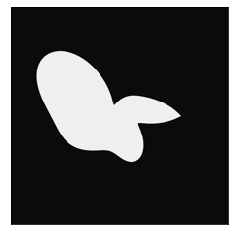

In [ ]:
# quick visualize the image
plt.pcolormesh(np.flipud(image_matrix),cmap='gray') # flip so y axis is correct
plt.axis('square')
plt.xticks([])
plt.yticks([])

In [33]:
# load a grid of evenly spaced ims in shape space
start=0.2; stop=4.8; nsteps_main=4
grid_x = np.round(np.linspace(start,stop,nsteps_main),1)
grid_y = np.round(np.linspace(start,stop,nsteps_main),1)
x, y = np.meshgrid(grid_x, grid_y)
coords2load = np.column_stack((x.ravel(),y.ravel()))

nIms = np.shape(coords2load)[0]

input_width=224; input_height=224
image_grid = np.zeros([nIms, 3, input_width, input_height])

for ii in range(nIms):

#   fn = '/content/drive/My Drive/images/Shape_%.2f_%.2f.png'%(coords2load[ii,0],coords2load[ii,1])
  fn = os.path.join(image_dir, 'Shape_%.2f_%.2f.png'%(coords2load[ii,0],coords2load[ii,1]))
  print('loading from %s'%fn)
  im = Image.open(fn)
 
  im = im.resize([input_width, input_height])
  image_matrix = np.double(np.reshape(im.getdata(),[im.width, im.height]))

  image_grid[ii,:,:,:] = np.moveaxis(np.tile(np.expand_dims(image_matrix,2), [1,1,3]),[0,1,2],[1,2,0])


# now making it a tensor in the format the model needs
# should be [batchsize x nchannels x width x height]
# where nchannels is 3 for RGB
image_grid_tensor = torch.tensor(image_grid).double()


loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_0.20_0.20.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_1.70_0.20.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_3.30_0.20.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_4.80_0.20.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_0.20_1.70.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_1.70_1.70.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_3.30_1.70.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_4.80_1.70.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGr

In [69]:
# load a grid of evenly spaced ims in shape space (new)
start=0.1; stop=4.9; nsteps_main=4
grid_x = np.round(np.linspace(start,stop,nsteps_main),1)
grid_y = np.round(np.linspace(start,stop,nsteps_main),1)
x, y = np.meshgrid(grid_x, grid_y)
coords2load = np.column_stack((x.ravel(),y.ravel()))

nIms = np.shape(coords2load)[0]

input_width=224; input_height=224
image_grid = np.zeros([nIms, 3, input_width, input_height])

# transform = transforms.Compose([transforms.ToTensor()])
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

for ii in range(nIms):

#   fn = '/content/drive/My Drive/images/Shape_%.2f_%.2f.png'%(coords2load[ii,0],coords2load[ii,1])
  fn = os.path.join(image_dir, 'Shape_%.2f_%.2f.png'%(coords2load[ii,0],coords2load[ii,1]))
  print('loading from %s'%fn)
#   im = Image.open(fn)
  im = io.imread(fn)  
  im = np.tile(np.expand_dims(im,2), [1,1,3]).astype('double')/255
#
  im = transform(im)
 
  image_grid[ii,:,:,:] = im


# now making it a tensor in the format the model needs
# should be [batchsize x nchannels x width x height]
# where nchannels is 3 for RGB
image_grid_tensor = torch.tensor(image_grid).double()
# image_grid_tensor = image_grid

loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_0.10_0.10.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_1.70_0.10.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_3.30_0.10.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_4.90_0.10.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_0.10_1.70.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_1.70_1.70.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_3.30_1.70.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGrid3_adj_full_grey_small/Shape_4.90_1.70.png
loading from /mnt/neurosphere/serenceslab2/maggie/shapeDim/Stimuli/AmpGr

In [70]:
print(np.min(image_grid))
print(np.max(image_grid))

-0.7992978850929018
2.2042701525054467


In [51]:
np.shape(im)

torch.Size([3, 224, 224])

In [82]:
# Record intermediate activations during a fwd pass of the model
# Passing the 16 images in "grid" through the model at once here
# using forward hooks to do this - basically adding an additional method that gets run whenever the forward method of the model is called
# this blogpost is helpful for understanding this http://web.stanford.edu/~nanbhas/blog/forward-hook.html
model = models.alexnet(pretrained=True).double()  # has to be double otherwise throws error
model.eval()  # setting it to eval mode 

activ = OrderedDict()
hooks = OrderedDict()

# will loop over all the layers in the "features" module (which is a Sequential container of modules)
nfeaturelayers = 13
# would be better to get these names automatically but just manually creating list for now
# (can see this printed in full if you enter "model")
layer_names = ['1_Conv2d','1_ReLU','1_MaxPool2d','2_Conv2d','2_ReLU','2_MaxPool2d','3_Conv2d','3_ReLU','4_Conv2d','4_ReLU','5_Conv2d','5_ReLU','5_MaxPool2d']

def get_activ_fwd_hook(ii):

  def hook(self, input, output):
      # here "self" is the module the hook was added to, input and output are relative to that module (generally one of model.features[ii])
#       print('storing activations for layer %s'%layer_names[ii])
#       print('size is:')
#       print(output.size())
      activ[ii] = output.detach() # detach just means make a copy whose gradients we stop measuring
      if ii==0:
          print(activ[ii][0,0,10,10].numpy())
    
  return hook

# adding this "hook" to the module corresponding to each layer, so we'll save activations at each layer
# this only modifies the "graph" e.g. what the model code does when run, but doesn't actually run it yet.
for ii in range(nfeaturelayers):  
  hooks[ii] = model.features[ii].register_forward_hook(get_activ_fwd_hook(ii))

print(len(activ))
# do the forward pass of model, which now includes the forward hooks
# now the "activ" variable will get modified, because it gets altered during the hook function
out = model(image_grid_tensor)
# now activ is an OrderedDict storing my activations 
print(len(activ))
print(activ[0][0,0,10,10].numpy())
# removing the hooks now, because otherwise if we run this code block again they get added twice
for ii in range(nfeaturelayers):
  hooks[ii].remove()



0
-0.8193269573894582
13
0.0


In [83]:
# doing PCA to visualize for one layer of interest
layer2plot = 0

# first, reshape to [nIms x nUnits]
# disregarding difference between channels/spatial dims for now
nUnitsTotal = np.prod(np.shape(activ[layer2plot])[1:])
activ_full = np.reshape(activ[layer2plot].numpy(),[nIms, nUnitsTotal])
np.shape(activ_full)

# reduce dimensionality of whole matrix w PCA
pca = decomposition.PCA()
print('running pca (original size %d by %d)'%(np.shape(activ_full)[0], np.shape(activ_full)[1]))
pca.fit(activ_full)
scores = pca.transform(activ_full)

running pca (original size 16 by 193600)


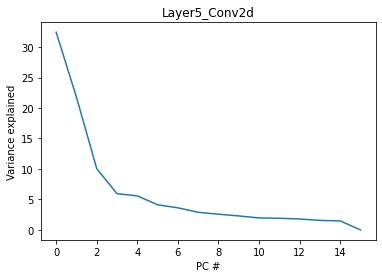

In [9]:
# plot percent of the variance expl by each PC
pct_expl_var = pca.explained_variance_
pct_expl_var = pct_expl_var/sum(pct_expl_var)*100
plt.figure();
plt.plot(pct_expl_var);
plt.xlabel('PC #');
plt.ylabel('Variance explained');
plt.title('Layer%s'%layer_names[layer2plot]);

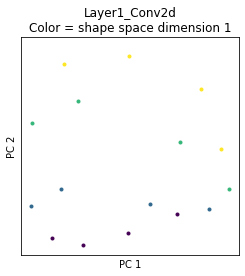

In [84]:
# plot the images in PC space
# Color by dimension 1 in shape space
viridis = cm.get_cmap('viridis')
cols2plot = viridis(np.linspace(0,1,len(grid_x)))
plt.figure();
for ii in range(len(grid_x)):
  inds2plot = np.where(coords2load[:,0]==grid_x[ii])[0]
  plt.plot(scores[inds2plot,0],scores[inds2plot,1],'.',color=cols2plot[ii,:])

plt.axis('square');
plt.xticks([]);
plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Layer%s\nColor = shape space dimension 1'%layer_names[layer2plot]);

In [74]:
coords2load

array([[0.1, 0.1],
       [1.7, 0.1],
       [3.3, 0.1],
       [4.9, 0.1],
       [0.1, 1.7],
       [1.7, 1.7],
       [3.3, 1.7],
       [4.9, 1.7],
       [0.1, 3.3],
       [1.7, 3.3],
       [3.3, 3.3],
       [4.9, 3.3],
       [0.1, 4.9],
       [1.7, 4.9],
       [3.3, 4.9],
       [4.9, 4.9]])

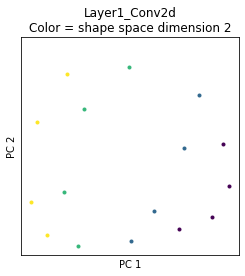

In [23]:
# plot the images in PC space
# color by dimension 2 in shape space
viridis = cm.get_cmap('viridis')
cols2plot = viridis(np.linspace(0,1,len(grid_y)))
plt.figure();
for ii in range(len(grid_y)):
  inds2plot = np.where(coords2load[:,1]==grid_y[ii])[0]
  plt.plot(scores[inds2plot,0],scores[inds2plot,1],'.',color=cols2plot[ii,:])

plt.axis('square');
plt.xticks([]);
plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Layer%s\nColor = shape space dimension 2'%layer_names[layer2plot]);

In [ ]:
# example of getting a prediction for a single image

# note you can use model.forward(data) or just model(data) to  make it run in fwd direction
# output = model.forward(image_tensor)  
output = model(image_tensor)
output.shape  # should be [batch_size x 1000]

# values in "outputs" are the raw activations output by the last linear layer, not logits.
# converting to a log-likelihood usign softmax function
output_ll = torch.softmax(output,1)

In [ ]:
# checking understanding of the softmax operation - should be same as just e^x/sum(e^x)
output_ll = torch.softmax(output,1)
print(output_ll[0][0])

num = torch.exp(output)
den = torch.tile(torch.unsqueeze(torch.sum(torch.exp(output),1),1),[1,1000])
output_ll = num/den
print(output_ll[0][0])
# prints should be same

tensor(1.4246e-124, dtype=torch.float64, grad_fn=<SelectBackward>)
tensor(1.4246e-124, dtype=torch.float64, grad_fn=<SelectBackward>)


In [ ]:
# now to get the predicted category, take the argmax here
# note even if you skip the softmax step, this should give same index for the max
torch.argmax(output_ll,1)

tensor([530, 530, 530, 530, 530, 530, 530, 530, 530, 530])

In [ ]:
# Record intermediate activations during a fwd pass of the model
# using forward hooks to do this - basically adding an additional method that gets run whenever the forward method of the model is called
# this blogpost is helpful for understanding this http://web.stanford.edu/~nanbhas/blog/forward-hook.html

activ = OrderedDict()
hooks = OrderedDict()

# will loop over all the layers in the "features" module (which is a Sequential container of modules)
nfeaturelayers = 13
# would be better to get these names automatically but just manually creating list for now
# (can see this printed in full if you enter "model")
layer_names = ['1_Conv2d','1_ReLU','1_MaxPool2d','2_Conv2d','2_ReLU','2_MaxPool2d','3_Conv2d','3_ReLU','4_Conv2d','4_ReLU','5_Conv2d','5_ReLU','5_MaxPool2d']

def get_activ_fwd_hook(ii):

  def hook(self, input, output):
      # here "self" is the module the hook was added to, input and output are relative to that module (generally one of model.features[ii])
      print('storing activations for layer %s'%layer_names[ii])
      print('size is:')
      print(output.size())
      activ[ii] = output.detach() # detach just means make a copy whose gradients we stop measuring
  
  return hook

# adding this "hook" to the module corresponding to each layer, so we'll save activations at each layer
# this only modifies the "graph" e.g. what the model code does when run, but doesn't actually run it yet.
for ii in range(nfeaturelayers):  
  hooks[ii] = model.features[ii].register_forward_hook(get_activ_fwd_hook(ii))

print(len(activ))
# do the forward pass of model, which now includes the forward hooks
# now the "activ" variable will get modified, because it gets altered during the hook function
out = model(image_tensor)
# now activ is an OrderedDict storing my activations 
print(len(activ))

# removing the hooks now, because otherwise if we run this code block again they get added twice
for ii in range(nfeaturelayers):
  hooks[ii].remove()



0
storing activations for layer 1_Conv2d
size is:
torch.Size([10, 64, 55, 55])
storing activations for layer 1_ReLU
size is:
torch.Size([10, 64, 55, 55])
storing activations for layer 1_MaxPool2d
size is:
torch.Size([10, 64, 27, 27])
storing activations for layer 2_Conv2d
size is:
torch.Size([10, 192, 27, 27])
storing activations for layer 2_ReLU
size is:
torch.Size([10, 192, 27, 27])
storing activations for layer 2_MaxPool2d
size is:
torch.Size([10, 192, 13, 13])
storing activations for layer 3_Conv2d
size is:
torch.Size([10, 384, 13, 13])
storing activations for layer 3_ReLU
size is:
torch.Size([10, 384, 13, 13])
storing activations for layer 4_Conv2d
size is:
torch.Size([10, 256, 13, 13])
storing activations for layer 4_ReLU
size is:
torch.Size([10, 256, 13, 13])
storing activations for layer 5_Conv2d
size is:
torch.Size([10, 256, 13, 13])
storing activations for layer 5_ReLU
size is:
torch.Size([10, 256, 13, 13])
storing activations for layer 5_MaxPool2d
size is:
torch.Size([10, 25

In [ ]:
for ii in model.features:
  print(ii)

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
# example code to do "forward hooks"
# do things in parallel/along with a fwd pass of the model.

def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())


model.features.register_forward_hook(printnorm)
model.classifier.register_forward_hook(printnorm)

out = model(image_tensor)

Inside Sequential forward

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([10, 3, 224, 224])
output size: torch.Size([10, 256, 6, 6])
output norm: tensor(12983.7576, dtype=torch.float64)
Inside Sequential forward

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([10, 9216])
output size: torch.Size([10, 1000])
output norm: tensor(5232.4023, dtype=torch.float64)
